                                                                       Roll No:20161170 Name:Shubh Maheshwari

# Computer Vision Assigment 1

    The Assignment comprises of various tasks 
        1. Camera Calibration(DLT)
        2. Camera Calibration(Ransac)
        3. Create a wireframe using Calibration Matrix(Ransac)
        4. Radial Distortion
        5. Zhang's algorithm 
        6. Create a wireframe using Calibration Matrix(Zhang)
   

In [5]:
# Important Imports
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Helper functions

def display_images(img_list, shape,fig_size=(8,8),is_gray=None):
    """
        Display multple images using matplotlib
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    if is_gray is None:
        is_gray = np.zeros(shape)
        
    m,n = shape
    fig = plt.figure(figsize=fig_size)
    
    for i in range(m):
        for j in range(n):
            ax = fig.add_subplot(m,n,i*n + j+1)
            if is_gray[i,j] == 1:
                ax.imshow(img_list[i][j],cmap='gray')
            else:
                ax.imshow(img_list[i][j])   
            ax.axis('off')

## Task1: Camera Calibration using DLT
     
    DLT is one of the robust methods for calibration
        Using DLT we calculate the interinsic(K) and extrinsic camera matrix(M=[R|T]) also known as calibration
    Derivation
        1. Define P
        2. Get the 6 points
        3. Restructure P to M
        4. Formulate least square error equation
        5. Caclulate SVD for M
        6. Prove minimum egien value is the solution for P
        7. Calualte P
        8. Calculate t from P
        9. QR decomposition for K and R
        10. Make sure R is positive 
    Code: 
        1. Vectorize p = p12
        2. Take 6 Points
        3. Create M
        3. Calulate SVD Get least eigen vector
        5. Calulate t, R, K
    Result:
Ref: [DLT](https://www.youtube.com/watch?v=ywternCEqSU)

### Get our 6 points of choice

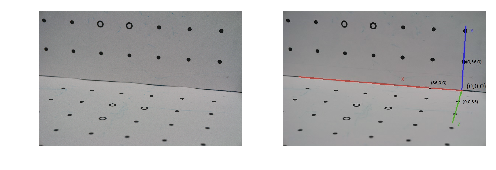

In [28]:
calb_im = cv2.imread('./images/IMG_5455.JPG')
ref_im = cv2.imread('./measurements.jpg')
display_images([[calb_im,ref_im]],(1,2))

`Instead of using Harris detector, as there are only 6 points I am manually finding their x,y poistions in the image`

In [29]:
# v,u image coordinates
img_coord = [[4826.01,2167.89],
             [3982.35,2091.31],
             [4738.43,2443.27],
             [4881.82,1374.34],
             [3878.07,2378.09],
             [4047.53,1322.20]]
img_coord = np.array(img_coord).astype('float32')

# z,y,x orignial cooridinates
real_coord = [[0 ,0 , 0],
              [36, 0, 0],
              [0 , 0,36],
              [0 ,36, 0],
              [36,0 ,36],
              [36,36,0]]
real_coord = np.array(real_coord).astype('float32')

# DLT function

In [45]:

def dlt(img_coord,real_coord,verbose=False,img=None):
    """
        Compute Camera calibration matrix using 6 2d and 3d points
        @param => img_coord: 2d matrix with image coordinates, shape=6,2
        @param => real_coord: 3d matrix with image coordinates, shape=6,3
    
        return: 
                ret: Error due to real world data 
                P => Projection matrix 
                K => Intrensic matrix, upper triangle matrix
                R => Rotation Matrix, 3x3 Matrix Orthogonal Matrix
                t => Translation Vector, 3x1 Translation Matrix
    """
#     Convert to float
    img_coord = np.array(img_coord).astype('float32')
    real_coord = np.array(real_coord).astype('float32')

#     Check for errors in input 
    if img_coord.shape != (6,2):
        print("2D coordinates of shape 6,2")
    
    if real_coord.shape != (6,3):
        print("3D coordinates of shape 6,3")

### Now using these coords we can define M        
    M = np.zeros((12,12))
    for i in range(6):
        X,Y,Z = real_coord[i,:]
        u,v = img_coord[i,:]
        M[2*i,:] =   [0,0,0,0,-X,-Y,-Z,-1,u*X,u*Y,u*Z,u]
        M[2*i+1,:] = [-X,-Y,-Z,-1,0,0,0,0,v*X,v*Y,v*Z,v]
    if verbose:
        print("M Matrix")
        print(M.astype('int'))
        
### Calulate the svd for M and return the minimum eigen vector as p 
    u,s,vh = np.linalg.svd(M)
    ind = np.argmin(s) # Generally 11
    Pt = vh[ind,:]
    P = Pt.reshape(3,4)

#     Caculate mse loss between predicted and real 2d points
    img_pred = P.dot(np.concatenate((real_coord.T,np.ones((1,6))),axis=0))
    img_pred = img_pred[[1,0],:]/img_pred[2,:]
    mse = np.mean((img_coord-img_pred.T)**2)
    if verbose:
    
        print("Projection Matrix:",P)
        print("Predicted 2d Points from 3d coordinates\n",img_pred.T)
        print("Original 2d Coords:\n",img_coord)
        print("MSE:",mse)
        
        if img is not None:
            for i in range(6):
                cv2.circle(img,(int(img_pred[0,i]),int(img_pred[1,i])  ),6,(0,255,0),int(0.03*img.shape[0]))

            plt.imshow(calb_im)
            plt.show()
        
# Calculate K,R,T
    hom = P[:,0:3]
    pt = P[:,3]
    hom_inv = np.linalg.inv(hom)
    t = hom_inv.dot(pt)
    R,K = np.linalg.qr(hom)
    K = K/K[2,2]

#     Calculate error due to using the lowest eighen value
    x = M.dot(Pt)
    error = x.dot(x)
    if verbose:
        print("Intrinsic Matrix:",K)
        print("Rotaion Matrix:",R)
        print("Translation Matrix:",t)
        

        print("Error",error)
        
    return P,K,R,t,error,mse

M Matrix
[[     0      0      0      0      0      0      0     -1      0      0
       0   4826]
 [     0      0      0     -1      0      0      0      0      0      0
       0   2167]
 [     0      0      0      0    -36      0      0     -1 143364      0
       0   3982]
 [   -36      0      0     -1      0      0      0      0  75287      0
       0   2091]
 [     0      0      0      0      0      0    -36     -1      0      0
  170583   4738]
 [     0      0    -36     -1      0      0      0      0      0      0
   87957   2443]
 [     0      0      0      0      0    -36      0     -1      0 175745
       0   4881]
 [     0    -36      0     -1      0      0      0      0      0  49476
       0   1374]
 [     0      0      0      0    -36      0    -36     -1 139610      0
  139610   3878]
 [   -36      0    -36     -1      0      0      0      0  85611      0
   85611   2378]
 [     0      0      0      0    -36    -36      0     -1 145711 145711
       0   4047]
 [   -36    

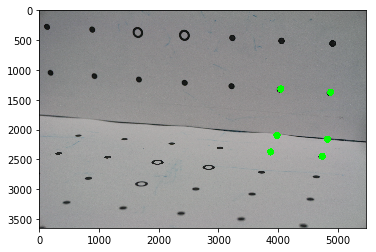

Intrinsic Matrix: [[-4.33363428e+04  4.70620049e+03 -9.39654476e+03]
 [-0.00000000e+00  4.25994874e+04 -1.34219408e+04]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotaion Matrix: [[-4.60071415e-02  9.98941111e-01  2.02589200e-05]
 [-9.98941111e-01 -4.60071419e-02  1.76705600e-05]
 [ 1.85839038e-05 -1.94244961e-05  1.00000000e+00]]
Translation Matrix: [  173.85393538  -795.46539864 -2238.36285262]
Error 2.756832372035938e-06


In [31]:
P,K,R,t,error,mse = dlt(img_coord,real_coord,verbose=True,img=calb_im)

## Task2: Camera Calibration using Ransac
    What is the algorithm 
        Ranac use DLT to give a more robust calibration 
    Code: 
        1. Take n Points
        2. Take random 6 points from n
        3. Calculate DCT and error
        4. Store the best 6 case
        5. Compute error on all points
Ref: [RANSAC](https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj3/html/rkatoch3/index.html)

In [65]:
# Let us define our N points. Took way too long to calculate then thought
# 2d points
u = [4.916500e+03,4.068500e+03,3.244500e+03,2.428500e+03,1.652500e+03,8.925000e+02,1.405000e+02,4.876500e+03, 4.036500e+03,3.220500e+03,2.436500e+03,1.676500e+03,9.245000e+02,1.965000e+02,4.724500e+03,3.868500e+03, 3.036500e+03,2.228500e+03,1.436500e+03,6.605000e+02,4.636500e+03,3.724500e+03,2.836500e+03,1.988500e+03, 1.156500e+03,3.405000e+02,4.548500e+03,3.572500e+03,2.628500e+03,1.716500e+03,8.365000e+02,4.420500e+03, 3.380500e+03,2.380500e+03,1.404500e+03,4.685000e+02]
v = [5.645000e+02,5.165000e+02,4.605000e+02,4.205000e+02,3.725000e+02,3.325000e+02,2.765000e+02,1.396500e+03, 1.332500e+03,1.276500e+03,1.212500e+03,1.164500e+03,1.100500e+03,1.044500e+03,2.452500e+03,2.372500e+03, 2.300500e+03,2.228500e+03,2.156500e+03,2.100500e+03,2.788500e+03,2.708500e+03,2.628500e+03,2.540500e+03, 2.460500e+03,2.388500e+03,3.164500e+03,3.076500e+03,2.988500e+03,2.908500e+03,2.804500e+03,3.596500e+03, 3.492500e+03,3.404500e+03,3.308500e+03,3.212500e+03]
u = np.array(u)
v = np.array(v)

# 3d points
X = []
X.extend(range(0,216+1,36))
X.extend(range(0,216+1,36))
X.extend(range(0,180+1,36))
X.extend(range(0,180+1,36))
X.extend(range(0,144+1,36))
X.extend(range(0,144+1,36))
X = np.array(X)
Y = np.vstack([72*np.ones((7,1)), 36*np.ones((7,1)), np.zeros((22,1))]).reshape(-1)
Z = np.vstack([np.zeros((14, 1)), 36*np.ones((6,1)), 72*np.ones((6,1)), 108*np.ones((5,1)), 144*np.ones((5,1))]).reshape(-1)

### Run Ransac

In [66]:
# Now from the 36 points take 6 random points to compute DLT, 200 iterations

n_iter = 200
batch_size = X.shape[0]
best_values = {}
least_mse = 1e10
for i in range(n_iter):
    mini_batch = np.random.choice(batch_size, 6)
    
    img_coord = np.array([u[mini_batch],v[mini_batch]]).T
    real_coord = np.array([X[mini_batch],Y[mini_batch], Z[mini_batch]]).T
    try:
        P,K,R,t,error,mse = dlt(img_coord,real_coord)
    except Exception as l:
#         print("Encountered Singular Matrix:",l)
        pass
    if error < least_mse:
        least_mse = error
        best_values['P'] = P
        best_values['R'] = R
        best_values['t'] = t
        best_values['K'] = K
        best_values['mse'] = mse
least_mse,best_values   

(2.7066817362216085e-53,
 {'K': array([[ 5.23388045e+00, -7.37961443e+22,  2.94093749e+00],
         [ 0.00000000e+00,  2.11577502e+27,  6.24155808e-04],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
  'P': array([[-4.51276333e-29,  6.68214034e-17,  4.47204003e-28,
           2.69331135e-25],
         [-2.47332984e-27,  9.11943733e-14, -1.39839574e-27,
           6.01207876e-25],
         [ 8.62816615e-32, -1.00000000e+00, -2.46519033e-31,
           1.25881285e-28]]),
  'R': array([[-1.82426634e-02, -6.36286093e-07,  9.99833589e-01],
         [-9.99833588e-01, -3.48732086e-05, -1.82426634e-02],
         [ 3.48790129e-05, -9.99999999e-01, -1.93302405e-15]]),
  'mse': 161.456879888349,
  't': array([-5.52086890e+02, -3.08249810e-28,  5.46544214e+02])})

### Calculate error on all elemets and the real and predicted points

MSE: 513.2822463657253


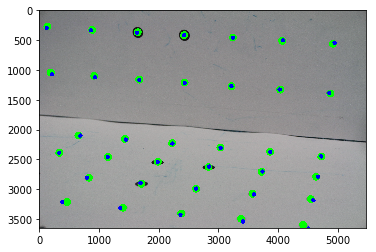

In [67]:
P = best_values['P']

ind_list = np.arange(batch_size)
img_coord = np.array([u[ind_list],v[ind_list]]).T
real_coord = np.array([X[ind_list],Y[ind_list], Z[ind_list]]).T

img_pred = P.dot(np.concatenate((real_coord.T,np.ones((1,batch_size))),axis=0))
img_pred = img_pred[[1,0],:]/img_pred[2,:]
mse = np.mean((img_coord-img_pred.T)**2)
print("MSE:",mse)

calb_im = cv2.imread('./images/IMG_5455.JPG')
for i in range(batch_size):
#     print(real_coord[i,:])
#     print(img_coord[i,:])
#     print(img_pred[:,i])
    cv2.circle(calb_im,(int(img_coord[i,0]),int(img_coord[i,1])  ),6,(0,255,0),120)
    cv2.circle(calb_im,(int(img_pred[0,i]),int(img_pred[1,i])  ),6,(0,0,255),60)

plt.imshow(calb_im)
plt.show()


## Correcting Radial Distorsion

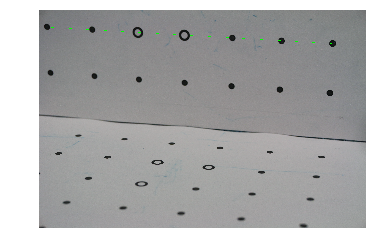

In [37]:
# Create a line on image to see distortion
calb_im = cv2.imread('./images/IMG_5455.JPG')
x1 = 4907
y1 = 561
x2 = 138
y2 = 287
new_im = cv2.line(calb_im, (x1, y1), (x2, y2), (0,255,0), 2)
plt.imshow(new_im)
plt.axis('off')
plt.show()

We can notice their is very less distortion in the image. Manually calculating it will be very hard

## Create a wireframes from 3d points
    We can calculate all the 3d points as all dots are seprated by 36mm
    Once we have the 3d points we use P(Projection Matrix) to get all the 
    2d points in the image
    Finally we use cv2 to draw the wireframe 

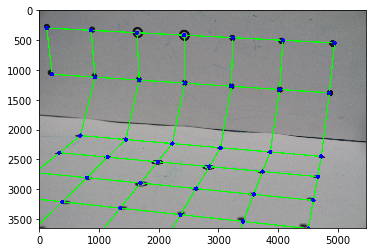

In [68]:
calb_im = cv2.imread('./images/IMG_5455.JPG')

def draw_lines(start,end):
    X1,Y1,Z1 = start
    X2,Y2,Z2 = end
    v1,u1,c1 = P.dot([X1,Y1,Z1,1])
    v2,u2,c2 = P.dot([X2,Y2,Z2,1])
    cv2.line(calb_im, (int(u1/c1), int(v1/c1)), (int(u2/c2), int(v2/c2)), (0,255,0), 20)
    cv2.circle(calb_im,(int(u1/c1), int(v1/c1)),6,(0,0,255),60)
    cv2.circle(calb_im,(int(u2/c2), int(v2/c2)),6,(0,0,255),60)
    

# Top 2 horizontal lines
for j in range(1,3):
    for i in range(6):
        X1 = i*36
        X2 = (i+1)*36
        Y = j*36
        Z = 0
        draw_lines((X1,Y,Z),(X2,Y,Z))

# Top verical lines
for i in range(7):
    X = i*36
    Y1 = 36
    Y2 = 72
    Z = 0
    draw_lines((X,Y1,Z),(X,Y2,Z))
    
# Out of plane lines
for i in range(6):
    X = i*36
    Y1 = 36
    Y2 = 0
    Z1 = 0
    Z2 = 36
    draw_lines((X,Y1,Z1),(X,Y2,Z2))
    
# Bottom horizontal lines
for k in range(1,5):
    for i in range(5):
        X1 = i*36
        X2 = (i+1)*36
        Y = 0
        Z = k*36
        draw_lines((X1,Y,Z),(X2,Y,Z))
        
# Bottom vertical lines
for i in range(6):
    for k in range(1,5):
        X = i*36
        Y = 0
        Z1 = k*36
        Z2 = (k+1)*36
        draw_lines((X,Y,Z1),(X,Y,Z2))        
    
plt.imshow(calb_im)
plt.show()

        
        

# Zhangs Algorithm for Calibration

In [69]:
# Store all images in a list,Total 15 images. Stroing as 3x5 matrix for better displaying images
zhang_img_list = []
row_list = []
for i,filename in enumerate(os.listdir('./images/')):
#     Skip the first image
    if i==0:
        continue
#     Read Image
    zhang_img = cv2.imread(os.path.join('./images/',filename))
    row_list.append(zhang_img)
    if len(row_list) == 5:
        zhang_img_list.append(row_list)
        row_list = []


### Find and display all the corners detected by the cv2.
### If we found corner points run calibration using these points
    Code inspired from the tutorial
    
###### Step1: Initialization 

In [40]:
zhang_img_list_vis = []
_3d_points=[]
_2d_points=[]

# Define 3rd world points if all corners are detected
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)
print(world_points.shape)

(48, 3)


###### Step 2 Loop over all images

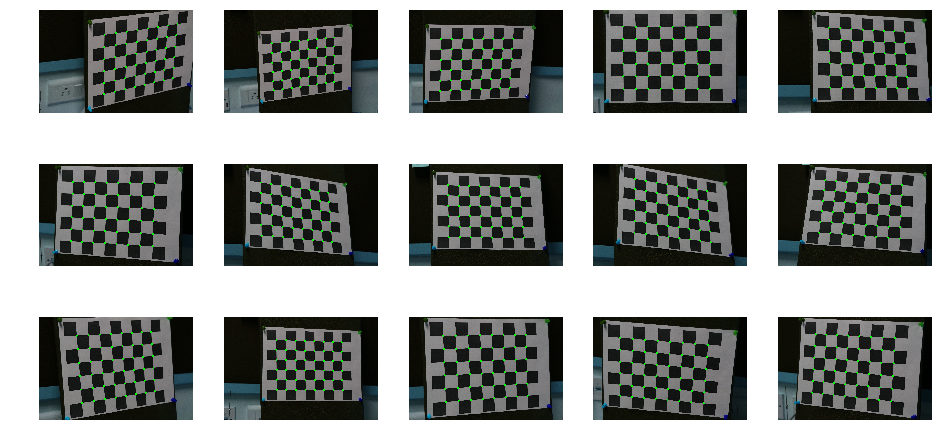

In [58]:
for row in zhang_img_list:
    row_list_vis = []
    for im in row:
#         print(im.shape)
        ret, corners = cv2.findChessboardCorners(im, (8,6))
        
        if ret: #add points only if checkerboard was correctly detected:
            _2d_points.append(corners) #append current 2D points  
            _3d_points.append(world_points) #3D points are always the same
        
        im_vis=im.copy()        
        for corner in corners:
            cv2.circle(im_vis,(corner[0,0],corner[0,1]),6,(0,255,0),60)
        row_list_vis.append(im_vis)
    zhang_img_list_vis.append(row_list_vis)

display_images(zhang_img_list_vis,shape=(3,5),fig_size=(16,8))

##### Step3: Run Opencv built-in calibration module

In [59]:
# Requires all 2d points and their corresponding 3d points and size of the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print ("Ret(Error):",ret)
print ("Mtx(Intrinsic Matrix):\n",mtx," ----------------------------------> [",mtx.shape,"]")
print ("Distortion:\n",dist," ----------> [",dist.shape,"]")
print ("All rotation vecs:\n",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]")
print ("Translation vecs:\n",tvecs," -------------------------------------------------------> [",tvecs[0].shape,"]")

Ret(Error): 2.4810222497615757
Mtx(Intrinsic Matrix):
 [[1.36634816e+04 0.00000000e+00 3.33651275e+03]
 [0.00000000e+00 1.36813888e+04 1.49657985e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]  ----------------------------------> [ (3, 3) ]
Distortion:
 [[ 9.51409607e-02  1.01150408e+01 -1.52797290e-02  2.87204086e-02
  -1.60701382e+02]]  ----------> [ (1, 5) ]
All rotation vecs:
 [array([[ 0.34957222],
       [-0.56388263],
       [-0.06027045]]), array([[ 0.22457259],
       [-0.40589059],
       [-0.05699634]]), array([[ 0.24427709],
       [-0.32261877],
       [ 0.02472153]]), array([[-0.0131805 ],
       [-0.05189049],
       [-0.00310176]]), array([[-0.19221837],
       [-0.38502272],
       [-0.00381435]]), array([[-0.00723452],
       [ 0.22652406],
       [ 0.03532837]]), array([[-0.37472804],
       [-0.48684336],
       [ 0.02851478]]), array([[-0.32566728],
       [-0.2223195 ],
       [-0.01742815]]), array([[-0.44150121],
       [-0.42569902],
       [ 0.05239111]

### Draw wireframes on all images using cv2.draw chessboard function

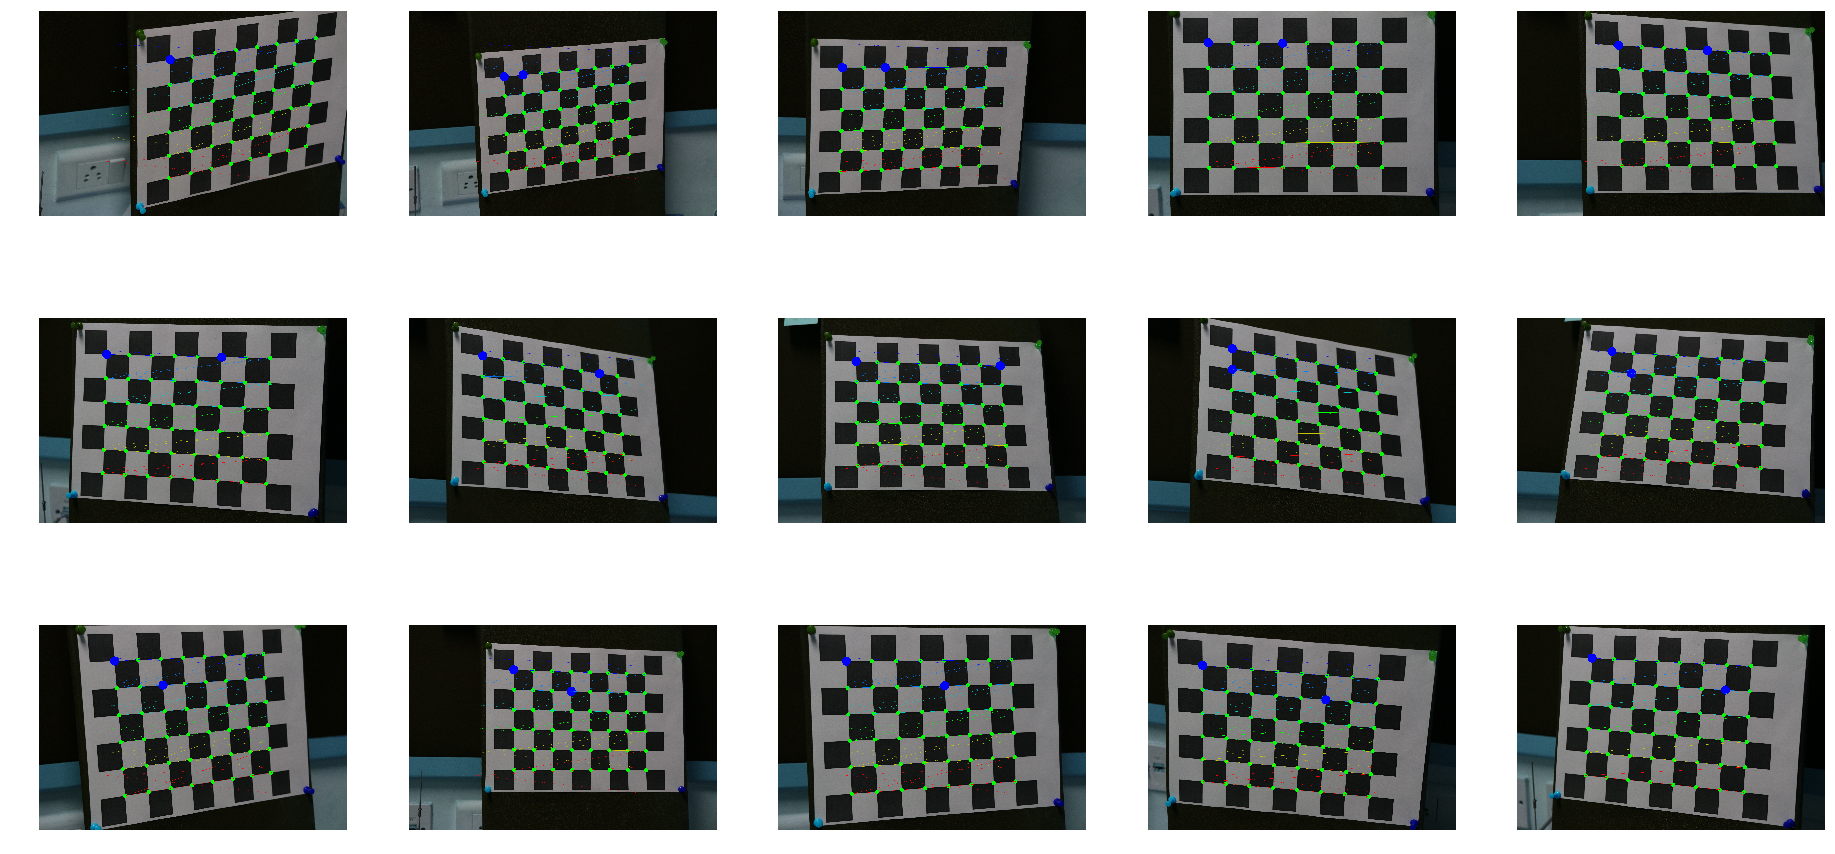

In [85]:
# Project 3d points of all cameras to 2d using rotation matrix and camera matrix
pred2d_list = []
h,w,c = zhang_img_list_vis[0][0].shape
for i in range(len(_3d_points)):
    pred2d, _ = cv2.projectPoints(_3d_points[i], rvecs[i], tvecs[i], mtx, dist)
    pred2d_list.append(pred2d)
    
    cv2.drawChessboardCorners(zhang_img_list_vis[i//5][i%5], (8,6), pred2d, 5) 

#     Draw center for the next question
    cv2.circle(zhang_img_list_vis[i//5][i%5],(pred2d[0,0,0],pred2d[0,0,1]),20,(0,0,255),120)
display_images(zhang_img_list_vis,shape=(3,5),fig_size=(32,16))

## Where is the origin

    For Zhang Algorithm we can see the blue dot on the chess board in the images above.
    For DLT we can notice the green dot on the paper in Figure 2, (use measurement.jpg as reference)


# Test on your own camera`

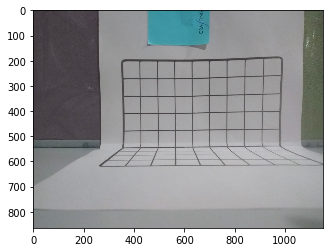

In [41]:
calb_im = cv2.imread('./phone.jpeg')
plt.imshow(calb_im)
plt.show()

M Matrix
[[   0    0    0    0    0    0    0   -1    0    0    0  432]
 [   0    0    0   -1    0    0    0    0    0    0    0  477]
 [   0    0    0    0   -1   -1    0   -1  500  500    0  500]
 [  -1   -1    0   -1    0    0    0    0  410  410    0  410]
 [   0    0    0    0   -1    1   -3   -1  477 -477 1431  477]
 [  -1    1   -3   -1    0    0    0    0  589 -589 1767  589]
 [   0    0    0    0   -6    1   -1   -1 5166 -861  861  861]
 [  -6    1   -1   -1    0    0    0    0 3318 -553  553  553]
 [   0    0    0    0    0   -3    0   -1    0 1278    0  426]
 [   0   -3    0   -1    0    0    0    0    0  819    0  273]
 [   0    0    0    0   -1   -2    0   -1  497  994    0  497]
 [  -1   -2    0   -1    0    0    0    0  341  682    0  341]]
Projection Matrix: [[-2.14066966e-03  1.05188944e-01  4.57631342e-02 -7.30111625e-01]
 [-1.08747647e-01  4.77669685e-03  6.92183957e-02 -6.61158866e-01]
 [-5.70709158e-06  3.61247616e-06  1.16795582e-04 -1.52980902e-03]]
Predicted 2d 

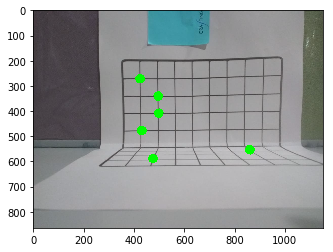

Intrinsic Matrix: [[ 973.38544262  -61.26564413 -627.38468094]
 [   0.          940.32597597  397.26973428]
 [   0.            0.            1.        ]]
Rotaion Matrix: [[-1.96809319e-02  9.99806311e-01 -3.19881738e-05]
 [-9.99806310e-01 -1.96809336e-02 -5.18504595e-05]
 [-5.24699737e-05  3.09615127e-05  9.99999998e-01]]
Translation Matrix: [ -2.36120996  -1.25728225 -13.17466588]
Error 3.185376838159553e-06


In [43]:
# v,u image coordinates
img_coord = [[432,477],
             [500,410],
             [477,589],
             [861,553],
             [426,273],
             [497,341]]
img_coord = np.array(img_coord).astype('float32')

# z,y,x orignial cooridinates
real_coord = [[0 ,0 , 0],
              [1, 1, 0],
              [1 , -1,3],
              [6 ,-1, 1],
              [0,3 ,0],
              [1,2,0]]
real_coord = np.array(real_coord).astype('float32')
P,K,R,t,error,mse = dlt(img_coord,real_coord,verbose=True,img=calb_im)

## RANSAC

## Zhangs Method

In [86]:
# Store all images in a list,Total 9 images. Stroing as 3x3 matrix for better displaying images
zhang_img_list = []
row_list = []
for i,filename in enumerate(os.listdir('./phone_images_zhang/')):
#     Read Image
    zhang_img = cv2.imread(os.path.join('./phone_images_zhang/',filename))
    row_list.append(zhang_img)
    if len(row_list) == 5:
        zhang_img_list.append(row_list)
        row_list = []

In [88]:
zhang_img_list_vis = []
_3d_points=[]
_2d_points=[]

# Define 3rd world points if all corners are detected
x,y=np.meshgrid(range(8),range(5))
world_points=np.hstack((x.reshape(40,1),y.reshape(40,1),np.zeros((40,1)))).astype(np.float32)
print(world_points.shape)

(40, 3)


Found Corners: False
Found Corners: False
Found Corners: False
Found Corners: False
Found Corners: False


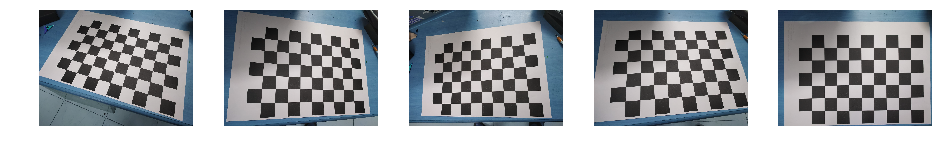

In [92]:
for row in zhang_img_list:
    row_list_vis = []
    for im in row:
#         print(im.shape)
        ret, corners = cv2.findChessboardCorners(im, (8,5))
        print("Found Corners:",ret)
        if ret: #add points only if checkerboard was correctly detected:
            _2d_points.append(corners) #append current 2D points  
            _3d_points.append(world_points) #3D points are always the same
        
            im_vis=im.copy()        
            for corner in corners:
                cv2.circle(im_vis,(corner[0,0],corner[0,1]),6,(0,255,0),int(0.03*im.shape[0]))
        else:
            im_vis = np.zeros((240,240))
        row_list_vis.append(im_vis)
    zhang_img_list_vis.append(row_list_vis)

display_images(zhang_img_list,shape=(1,5),fig_size=(16,8))

#### Not calculating Zhang 